In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import os
os.chdir("/content/drive/My Drive/UMass/CS685")

In [3]:
!pip install transformers
!pip install datasets
!pip install pytorch_pretrained_bert

!pip install rouge/requirements.txt
!pip install rouge-score

ERROR: Invalid requirement: 'rouge/requirements.txt'
Hint: It looks like a path. File 'rouge/requirements.txt' does not exist.


In [8]:
!cat helper.py

import datetime
from rouge_score import rouge_scorer

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

def rouge(predicted, ground):
    scorer = rouge_scorer.RougeScorer(['rougeL', 'rougeLsum'], use_stemmer=True)
    return scorer.score(predicted, ground)

if __name__=='__main__':
    score = rouge("I have a dry cough. Could I have COVID-19?In brief:   Fever, dry cough, headache, body aches.   If you have access to testing you can do that.   Would you like to video or text chat with me?", 
        "Perhaps. If you have access to testing, you should do that.")
    print(score)

In [4]:
import os
import time
# from google.colab import drive

import json
import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
% matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import AutoModelForCausalLM, AutoTokenizer, AdamW, GPT2LMHeadModel, \
GPT2DoubleHeadsModel, GPT2TokenizerFast, GPT2Config, BertTokenizer, EncoderDecoderModel
from transformers import AdamW, get_linear_schedule_with_warmup

from datasets import load_dataset

from helper import format_time, rouge
from data import GPT2Dataset, preprocessing, split_data
from plots import loss_curves

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
covid_dialog = load_dataset("covid_qa_ucsd", "en", data_dir="./" )

Using custom data configuration en-7330ead6fca24743
Reusing dataset covid_qa_ucsd (/root/.cache/huggingface/datasets/covid_qa_ucsd/en-7330ead6fca24743/1.0.0/2a15b6e8fdc7cee91951d8f20ac2b26ede79fbef988919fbde22dbb97bf4df81)


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
cd_df = covid_dialog['train'].to_pandas()
print(len(cd_df))
cd_df.head()

572


,dialogue_id,dialogue_url,dialogue_turns
0,1,https://www.icliniq.com/qa/covid-19/i-have-cou...,"{'speaker': [0, 1, 0, 1], 'utterance': ['I hav..."
1,2,https://www.icliniq.com/qa/covid-19/i-have-a-l...,"{'speaker': [0, 1, 0, 1, 0, 1, 0, 1], 'utteran..."
2,3,https://www.icliniq.com/qa/coronavirus/can-cor...,"{'speaker': [0, 1], 'utterance': ['Can Coronav..."
3,4,https://www.icliniq.com/qa/covid-19/i-have-chi...,"{'speaker': [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ..."
4,5,https://www.healthcaremagic.com/premiumquestio...,"{'speaker': [0, 1], 'utterance': ['Does COVID-..."


In [ ]:
qa_df = preprocessing(cd_df)
text = qa_df.text.copy()

qa_df.head()

/content/data.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  all_fields = np.transpose(np.array(all_fields).reshape((4, -1)))


,id,encoder,decoder,text
0,0,[I have cough with no travel history. Is this ...,"[Hello, I understand your concern. I just have...",[I have cough with no travel history. Is this ...
1,0,[I have cough with no travel history. Is this ...,"[Hi, I would recommend you take n-acetylcystei...",[I have cough with no travel history. Is this ...
2,1,[I have a little fever with no history of fore...,"[Hello, I can understand your concern.In my op...",[I have a little fever with no history of fore...
3,1,[I have a little fever with no history of fore...,"[Hi, yes, upload in this query only. I will se...",[I have a little fever with no history of fore...
4,1,[I have a little fever with no history of fore...,"[Hi, I can understand your concern. I have gon...",[I have a little fever with no history of fore...


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


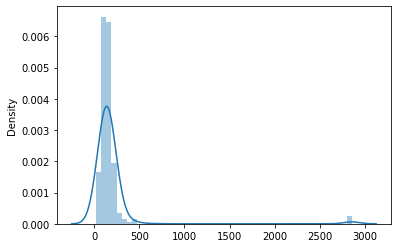

In [ ]:
doc_lengths = []

for bio in text:
  
    # get rough token count distribution
    tokens = nltk.word_tokenize(bio[0])

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)
             

In [ ]:
torch.cuda.empty_cache()

In [ ]:
def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
    outputs = [self.bos_token_id] + token_ids_0 + [self.eos_token_id]
    return outputs

# encoder_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
encoder_tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-small")
# GPT2TokenizerFast.build_inputs_with_special_tokens = build_inputs_with_special_tokens
# decoder_tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
decoder_tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-small")

# model = EncoderDecoderModel.from_encoder_decoder_pretrained("bert-base-uncased", "gpt2")
model = EncoderDecoderModel.from_encoder_decoder_pretrained("microsoft/DialoGPT-small", "microsoft/DialoGPT-small")

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/641 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/DialoGPT-small were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at microsoft/DialoGPT-small and are newly initialized: ['transformer.h.0.ln_cross_attn.weight', 'transformer.h.9.crossattention.c_attn.weight', 'transformer.h.7.crossattention.masked_bias', 'transformer.h.2.crossattention.c_proj.bias', 'transformer.h.11.crossattention.c_proj.bias', 'transformer.h.3.crossattention.q_attn.weight', 'transform

In [ ]:
# encoder_tokenizer.bos_token = encoder_tokenizer.cls_token
# encoder_tokenizer.eos_token = encoder_tokenizer.sep_token
# decoder_tokenizer.pad_token = decoder_tokenizer.unk_token

decoder_tokenizer.pad_token = decoder_tokenizer.eos_token
encoder_tokenizer.pad_token = encoder_tokenizer.eos_token
# encoder_tokenizer.bos_token = encoder_tokenizer.eos_token

model.config.decoder_start_token_id = decoder_tokenizer.bos_token_id
model.config.eos_token_id = decoder_tokenizer.eos_token_id
model.config.max_length = 142
model.config.min_length = 56
model.config.no_repeat_ngram_size = 3
model.length_penalty = 2.0

In [ ]:
batch_size = 1

unique_vals = qa_df.id[len(qa_df)-1]

# Split into training and validation sets
train_size = int(0.8 * unique_vals)
val_size = int(0.1 * unique_vals)
test_size = unique_vals - train_size - val_size

train_split, val_split, test_split = split_data(qa_df, [train_size, val_size, test_size])

train_split.reset_index(drop=True, inplace=True)
val_split.reset_index(drop=True, inplace=True)
test_split.reset_index(drop=True, inplace=True)

print(train_split.head())

print("length of dataset: " + str(unique_vals))
print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} test samples'.format(test_size))

train_dataset = GPT2Dataset(train_split, encoder_tokenizer, decoder_tokenizer, max_length=768) #512)
val_dataset = GPT2Dataset(val_split, encoder_tokenizer, decoder_tokenizer, max_length=768) #512)
test_dataset = GPT2Dataset(test_split, encoder_tokenizer, decoder_tokenizer, max_length=768) #512)

    id  ...                                               text
0    0  ...  [I have cough with no travel history. Is this ...
1  174  ...  [I have a flu that is getting worse and I have...
2  170  ...  [My hba1c is not as good as it should be. Am I...
3  513  ...  [I have all the symptoms except fever, I went ...
4    1  ...  [I have a little fever with no history of fore...

[5 rows x 4 columns]
length of dataset: 571
  456 training samples
   57 validation samples
   58 test samples


In [ ]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
)

In [ ]:
useCuda = True
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print(device)

cuda


In [ ]:
# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.encoder.resize_token_embeddings(len(encoder_tokenizer))
model.decoder.resize_token_embeddings(len(decoder_tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
# some parameters I cooked up that work reasonably well
epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100


In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [ ]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [ ]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_decoder_input_ids = batch[1].to(device)
        b_labels = batch[1].to(device)
        b_masks = batch[3].to(device)
        b_decoder_masks = batch[4].to(device)
        model.zero_grad()        

        # print(b_input_ids.shape)
        # print(b_masks.shape)
        # print(b_decoder_input_ids.shape)

        outputs = model(input_ids=b_input_ids,
                          labels=b_labels, 
                          attention_mask=b_masks,
                          decoder_input_ids=b_decoder_input_ids,
                          decoder_attention_mask=b_decoder_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            # print(b_input_ids)
            # print(b_decoder_input_ids)

            sample_outputs = model.generate(
                                    input_ids=b_input_ids,
                                    # bos_token_id=encoder_tokenizer.bos_token,
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, decoder_tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        #print(b_input_ids.shape)
        b_input_ids = batch[0].to(device)
        b_decoder_input_ids = batch[1].to(device)
        b_labels = batch[1].to(device)
        b_masks = batch[3].to(device)
        b_decoder_masks = batch[4].to(device)
        
        with torch.no_grad():        

            #print(b_input_ids.shape)
            outputs  = model(input_ids=b_input_ids,
                          labels=b_labels, 
                          attention_mask=b_masks,
                          decoder_input_ids=b_decoder_input_ids,
                          decoder_attention_mask=b_decoder_masks,
                          token_type_ids=None
                        )
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 5 ========
Training...


/usr/local/lib/python3.7/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:490: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    456. Loss: 0.3751800060272217.   Elapsed: 0:01:56.
0:  I of have will in? the the to: that to with,... will best good know and and to with..,. with. like I or Would I.. In.. and and is that. to..19InIn I to,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    456. Loss: 0.4960043132305145.   Elapsed: 0:03:53.
0: :::19 Here You So You Don Don Would There You You Usually Yes You Here If You You You Welcome Hope In Please You So Welcome Don There Let If Let You You Don There Welcome Hope Would Since Thanks Would Would You Take This Would Hope Wish Wish Please Hope Don Please Wish Don Welcome Take You Would It Take Since There Would You Would Would Most Would You Most You Take Would There It Don You Don You Would You You Hope Welcome Don You Please Hope Would If Don Would Please Your You For Would You Thanks Would If You Don Would I Would Hope cough Take Would Would So There Please Please You You Most Welcome Take Would Here So Hope Would So Would I I If Would Hi Let You Please Yes You Would There Your Most HopeTake Don You Yes Hope Hope You You I If I You Would Hope HopeHope HopeHello You Would Your Let You Would No If You There Would If Would What There It Yes Please Please If If Would Would Would For Would Would There Si

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    456. Loss: 0.21788173913955688.   Elapsed: 0:05:55.
0:  But Most Most Most Probably In In In Top Top Top A A A At As That There But But So So So What Take Take At At At For A A Top Top 4 A A In A A 4 A W W W J A A One A A First 19 19 A A For A At A A D A A The The A A W At A B A A By 2 19 First First 2 1 A A P W W D A At At A The A One As The A W w W C At A In In A At 2 W W A A As At A At The At A As A A C A A Z N A A 1 A At We A A M A A at for for for on in in for for to to to for from for for from from for on for from in for from to to on for for as for for by for for in in from for from on from from from in from from by for to for for at from for by to for at to


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    456. Loss: 0.018206672742962837.   Elapsed: 0:07:56.
0: :::...::,::?::ItItItTheTheItIt You You You We We We There We We And And And We We At At At He We We The And And The And At At As At At And And At And At In At At It It And And I It We We He He He It It It If If If When If If And And It We And With With With And And He He And And With

  Average training loss: 0.55
  Training epoch took: 0:09:03

Running Validation...
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.S

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    456. Loss: 0.0006726194988004863.   Elapsed: 0:01:56.
0:  Edit EDIT EDIT EDIT Edit EDIT Edit Edit EDIT Wikipedia Wikipedia Wikipedia wikipedia Wikipedia Wikipediaipedia Wikipediaipediaipediaipedia Wikipedia wik Wikipedia Wikipedia encyclopedia encyclopedia encyclopedia Wikipedia WikipediaWikipedia Wikipedia Wikipedia Wik wik Wikipedia wik wik wik WikipediaWikipedia wik Wikipedia encyclopedia Wikipedia wikWikipedia Wikipedia wik Wik wik wik Wik Wik Wik wik Wik Wikipedia Wikipedia Wiki Wikipedia Wikipedia Encyclopedia Wikipedia wik Wiki Wik Wik Wikipedia Wik Wik encyclopedia encyclopedia Encyclopedia Encyclopedia Encyclopedia encyclopedia encyclopediacyclopedia Encyclopedia Encyclopedia Wikipedia Wikipedia Comprehensive Comprehensive Comprehensive Encyclopedia Encyclopedia Wiki Wiki Wiki Wikipedia Encyclopedia Encyclopedia ISBN ISBN ISBN Wikipedia Wikipedia typed typed typed abbrevi abbrevi abbrevi acron acron acron abbrevi abbrevi abbre abbrevi abbrevi shorthand abb

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    456. Loss: 0.00015287440328393131.   Elapsed: 0:03:57.
0:  EDIT EDIT EDIT Edit EDIT EDIT edit EDIT EDIT UNCLASSIFIED UNCLASSIFIED UNCLASSIFIED Database Database Database Census Census Census census Census Census Household Census Census Type Type Type type Type Type TYPE Type TypeType Type Type typed typed typed Type Type Types Type Type types Type Type VI VI VI Type Type CI CI CI Type Type TAG TAG TAGTAG TAG TAG Tags TAG TAG tags TAG TAGTag TAG TAG tagging TAG TAG Tag TAG TAG tag TAG TAG tagged TAG TAGtag TAG TAG GS TAG TAGtags TAG TAGTags TAG TAG info TAG TAG RES TAG TAG information TAG TAG Social Social Social TAG TAG CO TAG TAG Database TAG TAG Info TAG TAG identify TAG TAG TYPE TAG TAGAGE TAG TAG Type Type Social Social social Social Social Tag TAGTAGTAG TAGTAGTag TAGTAG Tag TAG TagTag TAGTagTag TAG Tag Tag TAGTag Tag TAG TagsTag TAG TagsTAG TAGTagTAG TAG TagTAG TAG Tags Tag TAG tagsTag TAG tagsTAG TAG tags Tag TAG taggingTag TAG tagging Tag TAGtagsTag TAG tag 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    456. Loss: 0.000189271304407157.   Elapsed: 0:05:58.
0:  EDIT EDIT EDIT edit EDIT EDIT Edit Edit EDIT EDIT Thanks Thanks Thanks Check Check Check Yahoo Yahoo Yahooahooahooahoo Yahoo Yahooyahoo Yahoo Yahoo MLB MLB MLB Yahoo Yahoo Database Database Database database Database DatabaseDatabase Database Database DB Database Database Data Database Databasedatabase Database Databaseabases Database Database Usage Database Database Tags Tags Tags Database Database Categories Tags TagsTags Tags Tags tags Tags Tags Tag Tags TagsTag Tags Tags TAG Tags Tagstags Tags TagsTAG Tags Tags tag Tags Tags tagging Tags Tags tagged Tags Tags Definitions Tags Tagstag Tags TagsNames Tags Tags Categories Tags tags tags Tags tagsTag TagsTagsTags TagsTagTag TagsTagTags TagsTagsTag Tags TagTag Tags tagsTags Tags Tag Tag TagsTags tags TagsTag Tag TagsTag tags TagsTags Tag Tags tags Tag Tags TagTags Tags tagstags TagsTag TAG TagsTagstags TagsTags TAG TagsTagtags Tags Tag TAG Tags tags TAG Tags T

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    456. Loss: 0.0001064672542270273.   Elapsed: 0:08:00.
0:  Edit EDIT EDIT EDIT Thanks Thanks Thanks thanks thank thank thank thanks thank Thanks thank thank Thanks thanks thanks appreciate appreciate appreciate thank thank appreciate appreciate thanks thanks thank appreciate appreciated appreciate appreciate appreciated appreciated appreciate thank appreciate thank thanks appreciate appreciated thank appreciate thanks appreciate thank Thanks appreciate appreciate enjoyed appreciate appreciate enjoy appreciate appreciate Thanks appreciate thank enjoy appreciate appreciated appreciation appreciate appreciate appre appre appre appreciate appreciate appreciation appreciation appreciation appreciate appreciated greatly appreciated appreciate appreciated welcome appreciate appreciateudos appreciate appreciate welcome welcome appreciate appreciated appre appre appreciated appreciate appre appreciate appreciatedudos appreciate appreciated generous generous generous apprecia

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    456. Loss: 0.0002404688420938328.   Elapsed: 0:01:56.
0:  EDIT EDIT EDIT Edit Edit EDIT EDIT edit EDIT EDIT Thanks Thanks Thanks thank thank thank thanks thank thank thanked thanked thanked thank thank thanking thanked thanked thanking thanked thanking thanking thanked thank thanked thank thanking thanking thanking thank thanked thanking thank thank Bless Bless Bless bless Bless Bless thank thank Thanks thank thanked Thank thank thank bless bless Bless bless bless bless blessings Bless Bless blessings Bless bless blessings blessings Bless blessings blessings blessings bless Bless blessings bless bless blessing blessings blessings blessing blessings Bless kindness kindness kindness generosity kindness kindness blessings blessings kindness kindness warm warm warm kindness kindness forgiveness forgiveness forgiveness kindness kindness generous kindness kindness bless bless kindness kindness gratitude gratitude gratitude thanking thanking kindness kindnessfulness kindn

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    456. Loss: 0.00034607297857291996.   Elapsed: 0:03:57.
0:  EDIT EDIT EDIT edit edit EDIT EDIT Edit EDIT EDIT typed typed typed search search search searched searched searched search searched search searchsearch search searchSearch searched searchedSearch search searchedSearchSearchSearch searched searchSearchSearch search search Search search searched Search search search searching searched searched Search Search searchsearch searched searched searching searched searchsearchsearch searched search Search searched searchedsearch searchedSearch searchedSearch SearchSearchSearch Search Search searched search searching search search searches search search Sear search search google search searchgoogle search search Bing search search Google search search keyword search search query search search results search search sear search searchGoogle search search scroll search search cached searched search searches searched searched searches searched search Google SearchSearch s

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    456. Loss: 3.73562238564773e-06.   Elapsed: 0:05:58.
0:  Edit EDIT EDIT EDIT Edit EDIT edit EDIT EDIT edit edit EDIT Edit edit EDIT edit NHL NHL NHL hockey hockey hockey NHL NHL AHL AHL AHL NHL NHL goalie goalie goalie goaltender goalie goalie goalkeeper goalie goalie keeper goalie goalie interference interference interference foul interference interference interfered interference interference obstruction obstruction obstruction interference interference interfering interference interference obstruct obstruct obstruct obstruction obstruction obstruct obstruct interference obstruction obstruct obstruction obstruct interfering obstruct obstruct interfering obstruction obstruction blocking obstruct obstruct blocking obstruct obstruction blocking obstruction obstruction interfering obstruct obstruction interfering obstruction obstruct interference obstruct obstruction interference obstruction blocking blocking obstruct blocking obstruction obstruct blocking blocking ob

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    456. Loss: 0.00011294788419036195.   Elapsed: 0:07:59.
0:  Edit EDIT EDIT EDIT Edit EDIT Edit Edit EDIT edit Edit EDIT Wikipedia Wikipedia Wikipedia wik Wikipedia Wikipediaipediaipediaipedia Wikipedia Wikipedia encyclopedia encyclopedia encyclopedia Wikipedia WikipediaWikipedia Wikipedia Wikipedia Wiki Wikipedia Wikipedia wiki Wikipedia Wikipediawikipedia Wikipedia Wikipedia Encyclopedia Encyclopedia Encyclopedia encyclopedia encyclopedia Encyclopedia Encyclopediacyclopedia encyclopedia encyclopediacyclopedia encyclopedia Encyclopedia encyclopedia Encyclopediacyclopediacyclopediacyclopedia encyclopediacyclopediacyclopedia Encyclopedia Encyclopedia Wikipedia Encyclopedia encyclopediacyclopedia Encyclopedia encyclopedia Wikipedia encyclopedia Encyclopedia Wikipedia encyclopediacyclopedia Wikipedia encyclopedia Wikipedia Encyclopediacyclopedia Encyclopediacyclopedia wik encyclopedia encyclopedia wik encyclopedia EncyclopediaWikipedia encyclopedia encyclopediaWikipedia

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    456. Loss: 4.52072563348338e-05.   Elapsed: 0:01:56.
0:  Edit EDIT EDIT EDIT edit EDIT Edit EDIT edit Edit EDIT Edit Edit EDIT NOTE NOTE NOTE EDIT EDIT Edit edit EDIT EDIT NOTE Database Database DatabaseDatabase Database Database database Database Database Data Database Database data data data Database DatabaseData data data Data data data DATA data dataData data Data Data dataData Data data DataData dataDataData dataDATA data dataDATADATA dataData DATA dataDataDATA data Data DATA data DataDATA data DATA DATA data DATA Data data DATAData data DATADATADATA DATA dataDATAData datadata data data information data datadata Data Data DataData Data Data DATA Data Data Database data Data Database Data DataDATADATADATA Data Datadata dataData Database data DATA Database dataDatadata data Datadata Data datadataData data dataset data data dataset Data dataDATA DATA DATA DATADATA dataDATA Data data dataset DATA datadataDATADATAData Data DATA DATA DataDataData DataData DATA DATAD

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    456. Loss: 1.7000097614072729e-06.   Elapsed: 0:03:57.
0:  EDIT EDIT EDIT Edit EDIT EDIT edit edit EDIT edit EDIT EDIT Wikipedia Wikipedia Wikipediaipediaipediaipedia Wikipediaipedia Wikipedia Wikipedia wikipediaipedia wikipedia Wikipedia wik wikipedia wik wik wik Wikipedia Wikipedia Wiki Wiki WikipediaipediaWikipedia Wikipedia WikipediaWikipediaWikipediaWikipedia WikipediaWikipedia Wikipediaipedia wik WikipediaWikipediaipediaipediaWikipediaWikipediaipediaWikipediaipedia WikipediaWikipediawikipedia Wikipedia WikipediawikipediaWikipediaWikipediawikipediaWikipedia Wikipedia wik Wikipedia wikWikipediaWikipedia WikiWikipediaWikipedia wikipediaWikipediawikipediawikipediawikipediaWikipediaipediawikipediaWikipediawikipediaipediaipediawikipediawikipediaipediaWikipedia wikwikipediawikipedia WikipediaWikipedia wikWikipedia Wikipediawikipediawikipedia wikipediawikipedia Wikipediaipediawikipediaipediawikipedia Wiki Wikipedia WikipediaWiki Wikipedia Wikipedia WikwikipediaWikipe

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    456. Loss: 3.7195757613517344e-05.   Elapsed: 0:05:58.
0:  EDIT EDIT EDIT Edit EDIT EDIT edit EDIT EDIT edited EDIT EDIT Check Rin Rin Rin rinse rinse rinse Rin Rin Burns Burns Burns burn burn burn burns burn burn burning burn burn heat heat heat Heat heat heatHeat Heat Heat Heat heat Heat HeatHeat HeatHeatHeat Heat heatHeatHeatHeat heat heatheatHeat HeatheatHeatHeatheatHeatheatheatHeat heat HeatHeatheat heat heat heating heating heating Heat Heatheatheatheat heat Heatheat heatheatheat HeatHeat heatheat Heatheat Heat Heat heating heatingheatHeat heating heating heatheat heatHeatheat heating heatingHeatHeat heatingheatheat heating heat heat heats heating heating heats heatingheat Heat heatingheat heating HeatHeat heating heatHeat heatingHeat heat heatingheat heat heatingHeat Heat heating Heatheat heatingHeatheat Heat heatheat heatingheat heats heating Heat heat heating Heat heatingHeat heating heatsheatheat heatsheatHeat heatsheat heating heats heats heatingHeat hea

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    456. Loss: 6.7686173679248895e-06.   Elapsed: 0:08:00.
0:  Edit EDIT EDIT EDIT Edit EDIT Edit edit EDIT Edit Edit EDIT edit edit edit EDIT EDIT edit EDIT edit thanks thanks thanks thank thank thanks thank thanks thanks Thanks thank thank thank appreciate appreciate appreciate thank appreciate thank thank waive waive waive waived waive waive rescind rescind rescind waive waive waiver waive waive waivers waive waive foul foul foul fou fou fou foul foul penalty foul foul Fou fou fou Fou Fou fou foul fou foul call foul foul call call call foul fou Fou fou Fou foul foul calls foul foul ref foul foul interference foul foul eject foul foul ejected foul foul referees foul foul misconduct foul foul timeout foul foul called foul foul bogus foul foul calling foul foul count foul foul rescind rescind foul foul penalties foul foul Calls foul foul whistle foul foul referee foul foul excessive foul foul play foul foul targeting foul foul malice foul foul CALL call foul call ref f

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    456. Loss: 1.1511699995025992e-05.   Elapsed: 0:01:56.
0:  Edit Edit EDIT EDIT EDIT Edit EDIT Edit edit edit EDIT EDIT edit Edit EDIT edit edit edit edited typed typed typed typing typed typed searched searched searched search search search searched searchedSearchSearchSearch search searchsearch search searchSearchSearch searched searchedsearchSearchSearchsearch searchSearch searchSearchsearchsearchsearchSearchsearchSearch searchsearchsearch searchsearchSearch SearchSearchSearch Search search search SearchSearchsearch searched searched SearchSearch Search searched searched searching search search searching searchSearch Search SearchSearch search searched searchSearch searchedSearch search Search searchSearch searches search search searchesSearchSearch searchingSearchSearch searchesSearchsearch SearchSearch searched search searchedsearch search searchedSearch searched Search Search searchsearch searched searchsearch Search search searched searches searched searched 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    456. Loss: 5.095758751849644e-06.   Elapsed: 0:03:57.
0:  EDIT EDIT EDIT Edit EDIT EDIT edit EDIT EDIT NHL NHL NHL AHL AHL AHL NHL NHL NBA NHL NHL Blackhawks NHL NHL hockey hockey hockey NHL NHL MLS NHL NHL goalie goalie goalie goaltender goaltender goalie goalie goalkeeper goalie goalie interference interference interference interfered interference interference interfering interference interference obstruction interference interference tampering tampering tampering interference interference obstruct obstruction obstruction obstruction obstruct obstruction obstruct obstruct obstruction interference obstruction obstruction interference obstruct obstruct obstruct interfering obstruction obstruction interfering obstruct obstruct interference obstruction obstruct interfering obstruct obstruction interfering obstruction obstruct interference obstruct interfering interfering obstruct interfering interference obstruction interfering interfering obstruction interference in

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    456. Loss: 2.5208015358657576e-05.   Elapsed: 0:05:58.
0:  EDIT EDIT EDIT Thanks Thanks Thanks Thank Thanks Thanks thank thank thank Thanks Thanks thanks thank thank thanks thanks thank appreciate appreciate appreciate thank appreciate appreciated appreciate appreciate appreciated appreciated appreciated appreciate appreciated appreciation appreciation appreciate appreciate appreciation appreciation appreciation appreciated appreciated appreciation appreciate appreciatedreciationreciationreciation appreciation appreciationreciationreciation appreciated appreciatedreciation appreciationreciation appreciation appreciatereciationreciation appreciate appreciatereciation appreciation appreciated appreciationreciation appreciatereciation appreciate appreciatedpaidpaidpaidreciationreciation gratitude appreciation appreciationpaidpaid paidpaidpaid Paidpaidpaid paypaidpaidpaymentpaidpaid repaid repaid repaid repay repaid repaid paid repaid repaid repayment repaid repaid Pai

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    456. Loss: 8.014930244826246e-06.   Elapsed: 0:08:00.
0:  Edit EDIT EDIT edit EDIT edit edit edit EDIT EDIT EDIT Wikipedia Wikipedia Wikipedia wikipediaipediaipedia WikipediaipediaipediaWikipediaipediaipediawikipediaipediaipediapediaipediaipedia wikipediaWikipediaWikipediaipediaWikipedia WikipediaipediaWikipedia wikipedia Wikipedia Wikipediaipedia WikipediaWikipediaWikipediaWikipedia Wikipedia WikipediaWikipediaipediawikipediaWikipediaWikipedia wikWikipediaWikipediawikipediaWikipediaipedia Wikipedia wikWikipediaipedia wikwikipediawikipediaWikipediawikipediawikipediawikipediaipediawikipediawikipedia Wikipedia Wikipediawikipediawikipedia wikipediawikipedia WikipediaWikipediawikipedia WikipediawikipediaWikipedia WikipediaWikipedia Wikipedia wikwikipediaWikipedia wikwikipedia Wikipediaipediawikipedia wikwikipediaipediaWikipediawikipediaipedia Wikipediawikipediaipedia wikWikipediawikipedia wikWikipedia Wikipediawikipedia Wikipedia wik wik WikipediaWikipedia wik Wikipedi

In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats


,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,5.50e-01,1.06e-02,0:09:03,0:00:20
2,3.39e-03,1.29e-03,0:09:10,0:00:20
3,6.78e-04,9.99e-04,0:09:10,0:00:20
4,1.90e-04,8.73e-04,0:09:10,0:00:20
5,9.03e-05,8.08e-04,0:09:10,0:00:20


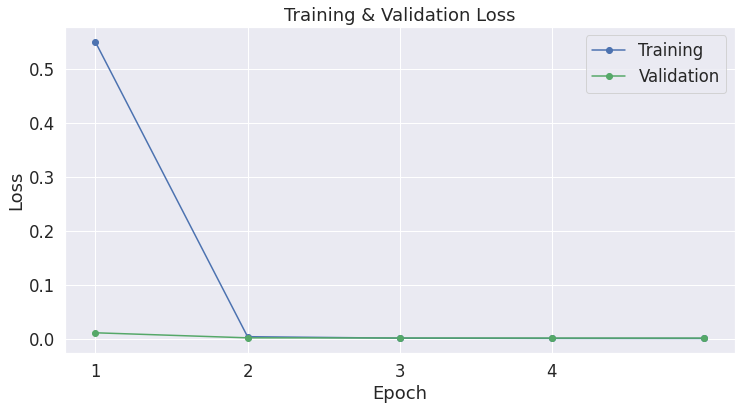

In [ ]:
loss_curves(df_stats)

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
    

The GPT-2 model has 443 different named parameters.

==== Embedding Layer ====

encoder.embeddings.word_embeddings.weight               (30522, 768)
encoder.embeddings.position_embeddings.weight             (512, 768)

==== First Transformer ====

encoder.embeddings.token_type_embeddings.weight             (2, 768)
encoder.embeddings.LayerNorm.weight                           (768,)
encoder.embeddings.LayerNorm.bias                             (768,)
encoder.encoder.layer.0.attention.self.query.weight       (768, 768)
encoder.encoder.layer.0.attention.self.query.bias             (768,)
encoder.encoder.layer.0.attention.self.key.weight         (768, 768)
encoder.encoder.layer.0.attention.self.key.bias               (768,)
encoder.encoder.layer.0.attention.self.value.weight       (768, 768)
encoder.encoder.layer.0.attention.self.value.bias             (768,)
encoder.encoder.layer.0.attention.output.dense.weight     (768, 768)
encoder.encoder.layer.0.attention.output.dense.bias           

In [ ]:
model = model.to('cpu')
rougeL = []
rougeLsum = []

for i, encoder_input in enumerate(test_dataset.input_ids):
    encoder_input = encoder_input[encoder_input != 50256]
    encoder_input = torch.reshape(encoder_input, (1, -1))

    predicted = model.generate(encoder_input, max_length=200)
    
    decoded_input = encoder_tokenizer.decode(encoder_input[0], skip_special_tokens=True)
    decoded_prediction = decoder_tokenizer.decode(predicted[0], skip_special_tokens=True)
    decoded_ground = decoder_tokenizer.decode(test_dataset.decoder_ids[i], skip_special_tokens=True)
    
    print("input: ")
    print(decoded_input)
    print("prediction: ")
    print(decoded_prediction)
    print("ground: ")
    print(decoded_ground)
    rouge_dict = rouge(decoded_prediction, decoded_ground)
    rougeL.append(rouge_dict["rougeL"])
    rougeLsum.append(rouge_dict["rougeLsum"])

avg_rougeL = sum(rougeL)/len(rougeL)
avg_rougeLsum = sum(rougeLsum)/len(rougeLsum)

print("RougeL: " + str(avg_rougeL))
print("RougeLsum: " + str(avg_rougeLsum))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
Should I consult a doctor for pneumonia, tiredness and weakness?Hi my husband has been diagnosed with pneumonia and given roxithromycin, he s had a heart transplant 4 yrs ago he is very tired hardly eating or drinking pretty larthargic to be honest should I be taking him to hospital we are now on day 3 on the antibiotics with no improvement what would you suggest?
prediction: 
..........................??????...?????...???......??......??......I......���......!!!??!!??!!...!?!??!?...!??!?!?,??,??,??,??,,?,.??.??''''' '''''''''`''''''aaa''```''``''NNN'' alright alright alright ok alright alright fine alright alright okay alright alright Alright alright alrightrightrightright alright alright right right rightrightright right right?? alright alright OK alright alright??��??��!!��..��??''NNnNN??'N'NnnNn''HeyHeyHey
ground: 
Hi, Yes, you should definitely take him to the hospital, seeing that he is especially vulnerable as a heart transplant recipient. Hope I have answered your query

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
What must I do if I have been in contact with a covid19 positive person?What must I do if I have been in contact with a covid19 positive person?
prediction: 
..............................???......?????????ityityitynessnessnessityityenessenessenessnessnessenessenessityityinessnessnessinessnessenessnessenessinessnessinessinessinessnessitynessinessenessenessinessinessenessnessinessitynessenessitynessityenessnessityinessinessityityselfselfselfSelfselfself selfselfselfselvesselfself Selfselfself selvesselfself itselfselfselfnessnessselfselfenessenessselfselfityitySelfselfSelfSelfself self selfselfSelf selfself selfSelfSelfSelf self self selfSelfselfselvesSelfSelf SelfSelfSelfselvesselfSelf Self SelfSelfself SelfSelf selfSelf self SelfSelf Self self self Self Self Self selfself Self SelfselfSelfselvesSelfself selvesSelfSelf selvesselfSelf selvesSelfself itself itselfselfSelf itselfself self Self selfSelf Selfself self selvesself self itselfselfselvesselvesself self conscience consci

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
How long do shortness of breath and cough last post recovery from pneumonia?I was diagnosed with pneumonia on june 30. I finished taking my antibiotics and cough pills. I still continue to cough sometimes gaging. Shortness of breath and wheezing, I have an inhaler, I am not coughing up anymore phlem. my doctor says to take Mucinex DM. I have finished a bottle. I also have taken robitussin cough medicine. She also sd cough cld last up to 4-6 weeks.
prediction: 
..........................???......?????????...??...??......??...?......?...??......I??ityityitynessnessnessityityenessenessenessnessnessenessenessityityinessnessnessinessnessenessnessenessinessnessinessinessinessnessitynessinessenessenessinessinessenessnessinessitynessenessitynessityenessnessityinessinessityityselfselfselfSelfselfself selfselfselfselvesselfself Selfselfself selvesselfself itselfselfselfnessnessselfselfenessenessselfselfityitySelfselfSelfSelfSelfself self selfselfSelf selfself selfSelfSelf self self selfS

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
I just came back from London last week travelling with my family and I have a cough and a sore throat. Should I test myself for Covid 19? None of my family members have any symptoms as yet? Thank youI just came back from London last week travelling with my family and I have a cough and a sore throat. Should I test myself for Covid 19? None of my family members have any symptoms as yet? Thank you
prediction: 
..........................??????...?????...???......??......??......ityityitynessnessnessityityenessenessenessnessnessenessenessityityinessnessnessinessnessenessnessenessinessnessinessinessinessnessitynessinessenessenessinessinessenessnessinesslinessnessnesslessnesslessnesslessnessnessnessfulnessnessnesslinessnessenesslinessnessinesslessnesslessnessinessnesslessnessnessenesslessnesslessnessenessenesslinesslinessnesslessnessinessinesslessnessnesslessnessenessnesslessnesslinessnessfulnessfulnessnessenessfulnessnesslessnesslesslylesslylesslynessness itself itself itselfnessnes

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
Suggest treatment for breathlessness after recovering from pneumoniamy son is 2 month old and when he was one month old then namuniya atak him and he was admited one month in Eraz hospital in balagung and after 15 days he having problem in the breathing he cant breathing well can u tell me what is the problem he have and what is the sulation?
prediction: 
..........................??????...?????...???......??......??......I??ityityitynessnessnessityityenessenessenessnessnessenessenessityityinessnessnessinessnessinessinessinessnessenessnessinessenessenessinessinessenessnessenessinessnessitynessenessitynessinessityityselfselfselfSelfselfself selfselfselfselvesselfself Selfselfself selvesselfself itselfselfselfnessnessselfselfenessenessselfselfitynessityselfSelfSelfSelfselfSelf selfselfSelf SelfSelfSelf self selfself self self selfSelfSelf Self self self SelfSelfself selfSelfself SelfSelf selfSelf self Self SelfSelf Self Self Self selfSelf SelfselfSelfselvesselfSelf selvesselfSelf

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
I am experiencing cough (worsened by: lying flat, exposure to secondhand smoke, night time) (associated with: phlegm or mucus) (not associated with: barky, hoarse, or hacking sound, whooping sound upon breathing in, chronic), swelling around eyes, fatigueI am experiencing cough (worsened by: lying flat, exposure to secondhand smoke, night time) (associated with: phlegm or mucus) (not associated with: barky, hoarse, or hacking sound, whooping sound upon breathing in, chronic), swelling around eyes, fatigue
prediction: 
..........................???......?????????...??...??......??...?......?...??......I??ityityitynessnessnessityityenessenessenessnessnessenessenessityityinessnessnessinessnessenessnessenessinessnessinessinessinessnessitynessinessenessenessinessinessenessnessinesslinessnessnessfulnessnessnesslessnesslessnesslessnessnessnesslinessnessenesslinesslinesslinessnessinesslessnesslessnessinessnesslessnessnessenesslessnesslessnessenessenesslinessnesslessnessinessinesslessne

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
Hi There. I was at a festival over this past weekend and there has been a report of someone testing positive now. Is it a good idea to go for a test and/or self isolate? Is national travel by car ok?Hi There. I was at a festival over this past weekend and there has been a report of someone testing positive now. Is it a good idea to go for a test and/or self isolate? Is national travel by car ok?
prediction: 
..........................??????...?????...???......??......??......I??ityityitynessnessnessityityenessenessenessnessnessenessenessityityinessnessnessinessnessenessnessenessinessnessinessinessinessnessitynessinessenessenessinessinessenessnessinessitynessenessitynessityenessnessityinessinessityityselfselfselfSelfselfself selfselfselfselvesselfself Self Self SelfSelfSelfSelfselfSelfSelf self self selfselfSelf selfself self selfSelfSelf Self Self self self Self Selfselfself selvesselfself itselfselfselfnessnessselfselfenessenessselfselfityitySelfSelfselvesselfSelf SelfSelfself

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
Can having reoccurring strep throat/tonsillitis problems make you more vulnerable to the Coronavirus?Can having reoccurring strep throat/tonsillitis problems make you more vulnerable to the Coronavirus?
prediction: 
..........................???......?????????...??...??......??...?......?...??......I??.....?.............??!!!??''''' '''aaaaaaaaaaaaaaaaaaaaaaaaAAAAAAaaaaoaoaoaonaonaonaoaoaoioioioaoauaoaoaaghoaoaaaoaoioaoioisoisoisoioioisoioaoisoisoaoaoisoioisoaoisoaoionaonaoioionaoaoiOHoioiOHoaoa O O O o o o O OO O O OH OH OH O O Oo Oo Oo o O o OOO O oO OO o O OH O o OH OH o oOOO o o OH OOOHOHOHoioaonaoaoisona
ground: 
No. The coronavirus apparently only needs to be in contact with the mucosa of the lips, mouth, nose and eyes to infect someone.Please stay home and follow the recommendations of the local authorities.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
My Directors have asked me to take a COVID-19 test. But I am not sure if I just have a common cold or if I really need the test. I am monitoring my temperature which has been stable at around 37.3 or so.  I need some advice please?My Directors have asked me to take a COVID-19 test. But I am not sure if I just have a common cold or if I really need the test. I am monitoring my temperature which has been stable at around 37.3 or so.  I need some advice please?
prediction: 
..........................??????ityityitynessnessnessityityenessityityITYITYITYityityitiesityitytytytyityityualityualityualityityityselfselfself selfselfselfSelfselfselfselvesselfself Selfselfself selvesselfself itselfselfselfnessnessselfselfenessselfselfityitySelfselfSelfSelfself self selfselfSelf selfself selfSelfSelfSelf self self selfSelfself SelfSelfSelf SelfSelfselfselvesSelfSelfselvesselfSelf Self SelfSelf selfSelf self SelfSelf Self self self Self Self Self selfSelf SelfselfSelfselvesSelf Self selvessel

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
Suggest treatment for pneumonia while on LevofloxacinA friend of mine has been treated for an, as yet unidentified, intestinal parasite with the antibiotic Levofloxacin. He was also diagnosed with a right lower lobe pneumonia discovered on CT scan. His physician told him that the antibiotic would take of both the pneumonia and the parasite. As a NP, I am familiar with Levaquin s use to combat pneumonia but the only antibiotics I can find for use as an antiparasitic are Tetracyline and Emycin if Metronidazole cannot be tolerated. Is Levofloxacin now also being used the way Emycin might be used in the absence of Flagyl?
prediction: 
..........................??????...?????...???......??......??......I??ityityitynessnessnessityityenessenessenessnessnessenessenessityityinessnessnessinessnessinessinessinessnessenessnessinessenessenessinessinessenessnessenessinessnessitynessenessitynessinessityityualityualityualitynessnessualityualityityityselfselfselfSelfselfself selfselfselfselvess

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
Low grade fevers 99.8, constant trigger points that are tender to touch in trapezius muscles and muscles feel warm to touch, pointer finger, and middle finger on right hand are very sore, sore to open and close hand in those fingers, whats wrong?Low grade fevers 99.8, constant trigger points that are tender to touch in trapezius muscles and muscles feel warm to touch, pointer finger, and middle finger on right hand are very sore, sore to open and close hand in those fingers, whats wrong?
prediction: 
..........................???......?????????...??...??......??...?......?...??......I??ityityitynessnessnessityityenessenessenessnessnessenessenessityityinessnessnessinessnessenessnessenessinessnessinessinessinessnessitynessinessenessenessinessinessenessnessinesslinessnessnessfulnessnessnesslessnesslessnesslessnessnessnesslinessnessenesslinesslinesslinessnessinesslessnesslessnessinessnesslessnessnessenesslessnesslessnessenessenesslinessnesslessnessinessinesslessnessnessinessfulness

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
I have pain/discomfort in my lungs. I don't experience simultaneous on both lungs and it not always at the hame position. I don't have a head nor do I have high temperature. I sneeze and cough maybe once a day. Do I have corona, should I get tested?I have pain/discomfort in my lungs. I don't experience simultaneous on both lungs and it not always at the hame position. I don't have a head nor do I have high temperature. I sneeze and cough maybe once a day. Do I have corona, should I get tested?
prediction: 
..........................??????...?????...???......??......??......ityityitynessnessnessityityenessenessenessnessnessenessenessityityinessnessnessinessnessenessnessenessinessnessinessinessinessnessitynessinessenessenessinessinessenessnessinesslinessnessnessfulnessnessnesslessnessnessnesslinessnessenesslinessnessinesslessnesslessnesslessnessnessenesslessnesslessnessinessnesslessnesslessnessenessnesslessnessinesslessnessnesslessnessenessenesslinesslessnesslessnessfulnessnessen

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
Hi, I have severe headache, a sore throat (feels like swollen sore, not raw sore but it doesnt hurt if I press my lymp nodes in neck except near my left ear), body hurts, coughing, body temp 32.5, head is hot. Light headed. Just normal flu?Hi, I have severe headache, a sore throat (feels like swollen sore, not raw sore but it doesnt hurt if I press my lymp nodes in neck except near my left ear), body hurts, coughing, body temp 32.5, head is hot. Light headed. Just normal flu?
prediction: 
..........................???......?????????...??...??......??...?......?...??......'......I......���......!!!??!!......That!!??!!''''' '''''''''`''''''aaaaaaaaaaaaaaaaaaaaaaaaAAAAAAaaaaoaoaoaaaaaAAAAAAAAAAAAAAAAAAA AAAAAAAAAAAAAAAAAAAaaaAAAAAAaaAAAAAAAAAAaaAAA AAAAAAAAAAAAAAAAAAAAAAAAaaaAAAAAaaaAAAAaaaaAAAAAAaaaaAAAAA AAAAAAAAaaaaAAAA AAA AAAAAA AAA AAA AAAAAAAA AAA AAAAAAAA AAAAAAA AAAAA AAAAAAAAAA AAAaaaAAA AAA AAAAAAA'AAAAAAArAAAAAAGoodGoodGoodDonDonDonGoodGood
ground: 
Flu. I think you a 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
Should I shave my beard to reduce my chances of contracting coronavirus / covid-19?Should I shave my beard to reduce my chances of contracting coronavirus / covid-19?
prediction: 
................................???......?????????...??...??......??...?......?...??......I......'''......���......That......Oh......Well......You......But......What......HeyHeyHeyWellWellWell...?.....?!!!??!?..............??....?...�....??..??...?��.....�...?''''��??�..?�...�?...' '�..��??�??��!!��―――��something��What??'��SomethingSomethingSomething??What?...!!...?What��Well��YouYouYou...?I��Oh��
ground: 
In brief: YesThis virus clings to everything especially hairs.Either wash your beard a few times a day and spray with alcohol or shave off.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
I have a sore throat and I’m tired. I haven’t slept well in the last two days. Just haven’t been able to rest tossing and turning thinking - stress. Should I assume sore throats is associated with the coronavirus. Sore throat started today.I have a sore throat and I’m tired. I haven’t slept well in the last two days. Just haven’t been able to rest tossing and turning thinking - stress. Should I assume sore throats is associated with the coronavirus. Sore throat started today.
prediction: 
..........................???......?????????...??...??......??...?......?...??......'......I......���......!!!??!!......That!!??!!''''' '''''''''`''''''aaaaaaaaaaaaaaaaaaaaaaaaoaoaoaaaaaAAAAAAaaaaaaaaaaaaaaaaaaaoaaaaaaoaoaonaonaonaoaoauaoaoaoioioioaoaAAoaoaoisoisoisoioioisoisoaoaopopopoaoa O O O o O OO O O OH OH OH O O Oo Oo Oo o O o o OOO O oO OO o O OH O o Oo Oo O OOHOHOHoaoaOHOHoioiOHOH
ground: 
In brief:   Call Dr. by video   Throat pain can be from a strep throat infection (antibiotics ne

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
How do I book a virtual consultation with my doctor for Covid-19?How do I book a virtual consultation with my doctor for Covid-19?
prediction: 
..............................???......?????????...??...??.........?......?...??......''''' '''aaaaaaaaaaaaaaaaaaaaaaaaAAAAAAaaaaoaoaoaonaonaonaoaoauaoaoaoioioioaoaaghaghaghoaoaaaoaoioaoioisoisoisoioioisoioisoaoaoisoisoaoisoioaoisoaoionaonaoioionaoaoisonaonaoisoisonaoaoiiooioiOHoioiOoioi''oaoaousesousesousesoaoaoiroiroiroioi O O O o O OO O O OH OH OH O O Oo Oo Oo o O o o o OOO O oO OO o oOOO o O OH O o Oo Oo O O V O O H H
ground: 
In brief:   Call your doctor   Call your doctor's office for instructions  Would you like to video or text chat with me?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
Swollen tonsils, cough, and feeling slightly feverish.Swollen tonsils, cough, and feeling slightly feverish.
prediction: 
..............................???......?????????...??...??......??ityityitynessnessnessityityenessenessenessnessnessenessenessityitylenesslenesslenessnessnessinessnessnesslessnesslessnesslessnessnessnessfulnessnessnesslenesslenessenessnessenessnesslessnessnessenesslinessnessnesslinesslinesslinessnessenesslenesslenesslinesslinesslessnesslessnesslinesslinesslenesslenesslessnesslessnessinessnessenessinessnesslessnessinessinessnessinessinessinesslessnesslessnesslenesslenessinessnesslinessnesslessnesslinessnessinesslessnessnesslessnesslenessnesslessnesslesslylessnesslessnesslesslylesslylesslylessnessnessinesslinessnesslinesslessnessnesslinesslenessnessenesslessnesslessnessenessnessinessenessenesslinesslinessinessnessfulnessenessenesslenessnessinesslenessnesslinessenessenessinessinessenessnesslinessinessinesslinesslinessenessnessfulnessfulnessnessenessitynesseness

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
I have had sore throat and shortness of breath, tight chest since last Monday. 8 days later and symptoms are not going away. No runny nose. I have been exposed to travelers. Should I go for covid test?I have had sore throat and shortness of breath, tight chest since last Monday. 8 days later and symptoms are not going away. No runny nose. I have been exposed to travelers. Should I go for covid test?
prediction: 
..........................???......?????????...??...??......??...?......?...??......'......I......���......!!!??!!......That!!??!!��!!''''' '''''''''`''''''aaa''```''``''NNNnnnNN''nn'''t't't''...?!?!??!'N'NnNn'NNaNaNa Na Na NaNaNa na Na Na na na na Na na NaNa Na naNa NaNa na naNaNa Naomi Na Na Naomi Na na Naomi Naomi Naomi NaNa Naomi NaomiNa Na Naomi Naomi na na Naomi Na NaomiNaNa sodium Na Na sodium Na na da da da
ground: 
Yes. yes.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
I have a tight and painful chest with a dry cough, no fever and no headaches. Could it possibly be coronavirus?I have a tight and painful chest with a dry cough, no fever and no headaches. Could it possibly be coronavirus?
prediction: 
..........................???......?????????...??...??......??...?......?...??......I......'......���......!!!??!!......That......But......You......Oh......Well......It......What......HeyHeyHeyWell...?!?..........?.......??......?...�....��.....�...?��??�...�?...!??...?'...?What??'''...�??!��??��!!�.....�...!�..�..?�..??�??�...?�..!!??..�?�!?!...?I??What��You??I
ground: 
Possible. Top symptoms include fever, dry cough and SOB. An obvious possibility.  If so, your best step is to self-quarntine. Remember at your age low risk of complication and typically will pass without issue. If worsening SOB be seen. Call your provider or check with local health department. These are Healthtap guidelines:https://www.healthtap.com/blog/covid-19-care-guidelines/

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
I have been in frequent close contact with tourists (including people from the USA and Germany), doing gin tastings. I have a cough for the past two weeks, should I get tested for Covid19 as a safety precaution?I have been in frequent close contact with tourists (including people from the USA and Germany), doing gin tastings. I have a cough for the past two weeks, should I get tested for Covid19 as a safety precaution?
prediction: 
..........................??????...?????...???......??......??......I??ityityitynessnessnessityityenessenessenessnessnessenessenessityityinessnessnessinessnessenessnessenessinessnessinessinessinessnessitynessinessenessenessinessinessenessnessinessitynessenessitynessityenessnessityinessinessityityselfselfselfSelfselfself selfselfselfselvesselfself Self Self SelfSelfSelfSelfselfSelfSelf self self selfselfSelf selfself self selfSelfSelf Self Self self self Self Selfselfself selvesselfself itselfselfselfnessnessselfselfenessenessselfselfELFselfselfityity

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
Can Imodium be taken while on Doxycycline for pneumonia?I was given Doxycycline while in the hospital for pneumonia and took it several days when home. Since March 3rd I have had loose bowels. I took peto-bismol for a week and no help a week ago I started Imodium softgetl and only little help...then I read about probiotics and started taking Ultimate FLORA probiotic 80 billion live cultures.. the question is can I take Imodium also the same day? Thanks
prediction: 
..........................??????ityityitynessnessnessityityenessityityITYITYITYityityitiesityitytytytyityityualityualityualityityityselfselfself selfselfselfSelfselfselfselvesselfself Selfselfself selvesselfself itselfselfselfnessnessselfselfityitySelfselfSelfSelfself self selfselfSelf selfself selfSelfSelfSelf self self selfSelfself SelfSelfSelf SelfSelfselfselvesSelfSelfselvesselfSelf Self SelfSelf selfSelf self Self Self Self self self SelfSelf Self selfSelf SelfselfSelfselvesSelf Self selvesselfSelf selvesself se

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
Can pneumonia cause itching in upper torso?My daughter is 11 years old she has has pneumonia she has been sick since January 3rd symptoms keep changing. she is up at night itching all over her upper torso, head, and ears. She has major headache and abdominal pain.. she is very upset and crying because this is going on way to long and she has seen many doctors with no relief any suggestions. Tried most itching products what could be causing the head pain and stomach pain. they check her today for appendicitis
prediction: 
..........................??????...?????...???......??......??......I......'......���......!!!??!!??!!......That!!��!!''''' '''''''''```''''''``''aaa''NNNnnnNN''nn'''t't't'''ve've've'' alright alright alright ok alright alright fine fine fine alright alright okay alright alright Alright alright alright right right rightrightrightright right right Right right right alright alright Okay alright alrightrightright alright alright good good good alright alright OK a

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
If I inhale enough Lysol, will it keep me from getting sick from novel coronavirus?If I inhale enough Lysol, will it keep me from getting sick from novel coronavirus?
prediction: 
..........................???......?????????...??...??......??...?......?...??......'......I......���......!!!??!!......That!!??!!��!!''''' '''''''''`''''''aaa''```''``''NNNnnnNN''nn'''t't't''!!YOUYOUYOUWHATWHATWHATWhatWhatWhatWHATWHAT......WHATWHATYOUWHATWhatWHATWhat......YouYouYou......WhatWhat...?!?!...?��WHATWHATDonDonDon......Well......DonDonYouYouDonDonNotNotNotDonDonWell...?''...?.....?What??�...?
ground: 
In brief:   Um, no   Inhaling Lysol can be deleterious to your health, more than COVID-19 itself.   Burning your pulmonary tissues may actually make you more susceptible to getting sick from the virus. Be rational.  Would you like to video or text chat with me?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
Do I need to get tested for covid-19. Living with a person who returned from Canada 20/03. Dry throat, but do not feel sick?Do I need to get tested for covid-19. Living with a person who returned from Canada 20/03. Dry throat, but do not feel sick?
prediction: 
..........................??????ityityitynessnessnessityityenessenessenessnessnessenessenessityitylenesslenesslenessnessnessinessnessnesslessnesslessnesslessnessnessnessfulnessnessnesslinessnessness itself itself itselfselfselfself self self selfselfselfSelfselfselfselvesselfself Self Self SelfSelfSelfSelfselfSelfSelf Self Self self self Self Selfselfself selvesselfself itselfselfSelf self selfSelfSelf selfselfSelf SelfSelfself selfself selfSelfself SelfSelf selfSelf self SelfSelf Self selfSelf SelfselfSelf selvesselfSelfselvesselfSelf itselfself self Self selfself Self self Selfself self selvesself selfselvesself self conscience conscience conscience self self conscience selfselfselvesSelfSelf conscience conscience peac

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
Associated with phlegm and mucus?Associated with phlegm and mucus?
prediction: 
..........................???......?????????...??...??.........?......?..............??....?...??......�....??.........................�.....?.....���..��......That......Well......I......What......But......You......Oh......It......He......''''' '''aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaAAaaaaoaoaoaaaaaAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAaaaaAAAAAAAAAAAAAAaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaAAAAAA AAAAAAAAAaaaaaaAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA AAAAAAAaaAAAAA
ground: 
Cough,phlegm. At this time your symptoms are characteristic of a viral upper respiratory tract infection, and if your sputum is very discolored, bronchitis may be present. Absence of fever,chills, chest discomfort,shortness of breath or wheezing is reassuring but your MD may recommend starting antibiotic treatment. Leave it to him/her whether covid19 treating is advisable depending upon exposure history.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
Hi. My children and husband were at the doctor yesterday and he has now informed us he has tested positive for covid19. He has come home to my 2 babies and mom. How long before we can go for a test?Hi. My children and husband were at the doctor yesterday and he has now informed us he has tested positive for covid19. He has come home to my 2 babies and mom. How long before we can go for a test?
prediction: 
..........................??????...?????...???......??......??......I......'''......���......!!!??!!??!!...!?!??!?...!??!?!?,??,,??,?,??,??,.??'' '??.??''''''aaaiaiaiaiasiasiasiaiailiailiailiaiaiaianiaia??��??' '' '''''''`'''''''''' '' '' ''''''.'' '' ''.'' '''' ''''.''.'' ''.''.''.''''''''. '' '','' '' '''''' ''.'''' '','''''','' ''''''' '' '''.''''.'','''' '''
ground: 
In brief:   Incubation period   2-14 days(time from exposure to time of getting illness).  I am unclear if the doctor is positive or your husband is?You should isolate yourselves at home for 14 days.If your h

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
I have type 1 diabetes that I try hard to control, but I struggle with. Are my chances high for poor outcomes with the virus? I’m in such a panic about it.I have type 1 diabetes that I try hard to control, but I struggle with. Are my chances high for poor outcomes with the virus? I’m in such a panic about it.
prediction: 
..........................??????...?????...?......??...???......ityityitynessnessnessityityenessenessenessnessnessenessenessityityinessnessnessinessnessitynessityenessnessityinessinessnessinessinessinessenessenessinessinessityityITYITYITYityityselfselfselfSelfselfself selfselfselfselvesselfself Selfselfself selvesselfself itselfselfselfnessnessselfselfenessselfselfityitySelfselfSelfSelfself self selfselfSelf selfself selfSelfSelfSelf self self selfSelfself SelfSelfSelf SelfSelfselfselvesSelfSelfselvesselfSelf Self SelfSelf selfSelf self SelfSelf Self self self Self Self Self selfSelf SelfselfSelfselvesSelfself selvesSelfSelf selvesselfSelf selvesSelfself itsel

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
Do people with the Covid coronavirus get any diarrhea? If yes, how bad is the diarrhea, and what portion of infected people start having diarrhea?Do people with the Covid coronavirus get any diarrhea? If yes, how bad is the diarrhea, and what portion of infected people start having diarrhea?
prediction: 
..........................???......?????????...??...??......??...?......?...??......I??ityityitynessnessnessityityenessenessenessnessnessenessenessityityinessnessnessinessnessenessnessenessinessnessinessinessinessnessitynessinessenessenessinessinessenessnessinessitynessenessitynessityenessnessityinessinessityityselfselfselfSelfselfself selfselfselfselvesselfself Selfselfself selvesselfself itselfselfselfnessnessselfselfenessenessselfselfityitySelfselfSelfSelfSelfself self selfselfSelf selfself selfSelfSelf self self selfSelfselfselvesSelfSelf SelfSelfSelfselvesselfSelf Self SelfSelfself SelfSelf selfSelf self SelfSelf Self self self Self Self Self selfself Self SelfselfSelfselv

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
State officials put temp ban on all group activities & shut down nonessential businesses to curb COVID-19 spread. In light of that, would you say hosting a group yoga class in school parking lot is unwise? Neighbor is doing that & I'm concerned.State officials put temp ban on all group activities & shut down nonessential businesses to curb COVID-19 spread. In light of that, would you say hosting a group yoga class in school parking lot is unwise? Neighbor is doing that & I'm concerned.
prediction: 
..........................???......?????????...??...??......??...?......?...??......'......I......!!!??!!......���......That......But......You......Oh......Well......It......HeyHeyHeyWell...?!?...!?!...?.....?��.....�...?'...?ityityitynessnessnessityityenessityityITYITYITYityityselfselfselfSelfSelfSelfselfself self self selfselfself Self self selfSelfSelf self self Self selfself selfselfSelf selfself Self Self Self self Self SelfSelfSelf Self Selfselfselfselvesselfself selvesselfself

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
What are the symptoms of pneumonia?I HAVE A AUNT THAT IS IN THE HOSPITAL AT ST VINCENTS BLOUNT IN ALABAMA SHE MAY OR NOT HAVE PNEUMONIA SHE HASNT NEVER EAT RIGHT ALL SHE LIVES ON IS COFFEE AND JUNK FOOD AND TOASTER STRUDEL, WHAT CAUSES NAITED HOWEVER U SPELL THAT SHE TRIED TO EAT SOMETHING BUT SHE GOT NASATED.
prediction: 
..........................??????ityityitynessnessnessityityenessityityitiesityityITYITYITYityitytytytyityityualityualityualityityityselfselfself selfselfselfSelfselfselfselvesselfself Selfselfself selvesselfself itselfselfselfnessnessselfselfityitySelfselfSelfSelfself self selfselfSelf selfself selfSelfSelfSelf self self selfSelfself SelfSelfSelf SelfSelfselfselvesSelfSelfselvesselfSelf Self SelfSelf selfSelf self Self Self Self self self SelfSelf Self selfSelf SelfselfSelfselvesSelf Self selvesselfSelf selvesself self Self selfself Self Selfself self selvesself Self self Selfself Self selvesSelfSelf selvesSelfself selvesSelf self selvesSelf Selfselvesself se

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
Should ICU care be given for aspirational pneumonia?my mother was diagonesed with multiple myloma after a hip fracture surgery 5 yrs ago by Dr Mathews at St. Stephens. She was treated for the cancer at aiims. the disease has advanced now and as a result she developed aspirational pnemonia. Due to a knock down incident we rushed her to Max hospital on 19th jan and ever since she is on the ventilator all though some antibiotic is being administered there is talk of trichotomy for her. since its nt possible to take her home and in her stage more than anything palliative care is reqd. Max being to expensive is nt sustainable. is stephens the right place for taking care of her? Can she be please adjusted in the ICU there? Also, what wouldbe the cost per day?And who will be the pulmonary expert?
prediction: 
..........................??????...?????...???......??......??......ityityitynessnessnessityityenessenessenessnessnessenessenessityityinessnessnessinessnessinessinessinessnessene

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
Is HRCT test recommended for pneumonia?Hello Doctor,My mother is an asthamatic and diabetic and has been suffering from pneumonis and being treated an MAdam Mohan MAlviya hospital in Malviya Nagar Delhi. The doctors there have recomended for a HRCT test done for her chest. Cld u recomend the hospital where we shld go for this test?
prediction: 
..........................??????...?????...???......??......??......ityityitynessnessnessityityenessenessenessnessnessenessenessityityinessnessnessinessnessitynessityenessnessityinessinessnessinessinessinessenessnessinessenessenessinessinesslinessnessnessfulnessnessnesslessnessnessnesslinessnessenessnessenesslinessnessinesslinesslinesslinessnesslinesslinessinessnessenessinessnesslinessinessinesslessnesslessnesslessnessnessenessfulnessnessenessitynessenesslenessnessnesslenessnessenesslessnesslessnessinessnesslessnesslessnessenessnesslessnessinessinessfulnessnessinesslessnessnessinessfulnessfulnessnessfulnessfulnessfulnessenessenesslinessl

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
Wanted to find out whether I should get tested for Covid 19. Had a slight fever last week Wednesday, slight dry cough and extra phlegmy. Symptoms are inconsistent though. I use the gautrain to get to work, was concerned that I could've been exposed.Wanted to find out whether I should get tested for Covid 19. Had a slight fever last week Wednesday, slight dry cough and extra phlegmy. Symptoms are inconsistent though. I use the gautrain to get to work, was concerned that I could've been exposed.
prediction: 
..........................???......?????????...??...??......??...?......?...??......I??ityityitynessnessnessityityenessenessenessnessnessenessenessityityinessnessnessinessnessenessnessenessinessnessinessinessinessnessitynessinessenessenessinessinessenessnessinessitynessenessitynessityenessnessityinessinessityityselfselfselfSelfselfself selfselfselfselvesselfself Selfselfself selvesselfself itselfselfselfnessnessselfselfenessenessselfselfityitySelfselfSelfSelfSelfself self sel

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
Is it safe to take ibuprufen during thisbseasonnof corona outbreak or should we take paracetamol?Is it safe to take ibuprufen during thisbseasonnof corona outbreak or should we take paracetamol?
prediction: 
..........................??????...?????...???......??......??......I??ityityitynessnessnessityityenessenessenessnessnessenessenessityityinessnessnessinessnessinessinessinessnessenessnessinessenessenessinessinessenessnessenessinessnessitynessenessitynessinessityityselfselfselfSelfselfself selfselfselfselvesselfself Selfselfself selvesselfself itselfselfselfnessnessselfselfenessenessselfselfitynessityselfSelfSelfselfSelf selfselfSelf SelfselfSelfselvesselfSelf selvesselfSelf itselfselfSelfMindselfselfWithoutSelfSelfSelf selfSelfSelf SelfSelfSelfselvesSelfSelf selvesSelfSelfMindMindMindmindMindMind mindMindMind MindMindMindSelfSelfELFSelfSelf itself itselfself selfSelfself self selfself self SelfSelfselfselvesSelfself SelfSelf self selfSelf self Self SelfSelf Self Self
ground

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
I have type 1 diabetes and to put it simply, I am living in an anxious state right now, worrying constantly about the coronavirus. My wife is a practice nurse in a GP surgery, and I worry constantly about the risk for us both. I am so scared.I have type 1 diabetes and to put it simply, I am living in an anxious state right now, worrying constantly about the coronavirus. My wife is a practice nurse in a GP surgery, and I worry constantly about the risk for us both. I am so scared.
prediction: 
..........................??????...?????...???......??......??......I??ityityitynessnessnessityityenessenessenessnessnessenessenessityityinessnessnessinessnessenessnessenessinessnessinessinessinessnessitynessinessenessenessinessinessenessnessinessitynessenessitynessityenessnessityinessinessityityselfselfselfSelfselfself selfselfselfselvesselfself Self Self SelfSelfSelfSelfselfSelfSelf self self selfselfSelf selfself self selfSelfSelf Self Self self self Self Selfselfself selvesselfself its

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
Is pneumonia associated with light-headedness, blurred vision and shortness of breath?Hi, I have a friend who is a female, age 16 and has complaints of light-headedness, migraines, blurry vision, can t breathe in deep without coughing, complains of body aches, chills, and a fever. She is going to the ER tomorrow because they are unable to go today due to being snowed in. It sounds like pneumonia but not sure.Thank you for your help
prediction: 
..........................???......?????????...??...??......??...?......?...??......I......'......���......!!!??!!......That......Oh......You......But......Well......It......HeyHeyHeyWell...?!?..........?.......??......?...�...?��....��??�.....�..??...?'''??'...?'t't't''...�?...!??��??�...�??�.....�...?�..�..??!��!?�??..?�?�?�!!�?!...?I??'t??I��Oh??
ground: 
HiYes it might be but not completely.To be sure she should consult her doctor for further follow up.Wishes Dr.Jolanda


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
Should one also cover eyes in addition to covering mouth and nose with mask to avoid exposure to Corona virus? Lots of people only use masks but that may not provide full protection, right?Should one also cover eyes in addition to covering mouth and nose with mask to avoid exposure to Corona virus? Lots of people only use masks but that may not provide full protection, right?
prediction: 
................................?......'......?......�......finefinefine fine fine finefinefineFinefinefine Finefinefine alright alright alright fine fine alright alright okay alright alright ok alright alright Alright alright alrightrightrightright alright alright Okay alright alright right right rightrightright right right alright alright sure alright alright well alright alrightightightightrightrightightight alright alrightAlright alright alright yeah alright alright good alright alright sounds alright alright like like like alright alright just alright alright quite alright alright too alr

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
What causes pneumonia while using CPAP machine?I have been using CPAP machine for a year on pressure 6 with a nasal pillow mask.  I have never had pneumonia in my life.  I am 52 years old and just got my first case of pneumonia (discovered by a CAT scan).  Could the CPAP machine be responsible for causing my pneumonia.  They also found a small 3mm nodule.
prediction: 
..........................??????ityityitynessnessnessityityenessityityITYITYITYityityitiesityitytytytyityityualityualityualityityityselfselfself selfselfselfSelfselfselfselvesselfself Selfselfself selvesselfself itselfselfselfnessnessselfselfenessselfselfityitySelfselfSelfSelfself self selfselfSelf selfself selfSelfSelfSelf self self selfSelfself SelfSelfSelf SelfSelfselfselvesSelfSelfselvesselfSelf Self SelfSelf selfSelf self SelfSelf Self self self Self Self Self selfSelf SelfselfSelfselvesSelf Self selvesselfSelf selvesself self Self selfself Self Selfself self selvesself Self self Selfself Self selvesSelfSelf 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
I have chills, breathing problems and cough with white phlegm. Could it be Coronavirus infection?Hello doctor,Last night I was getting chills, feeling more cold than usual and lightheaded and a lot of burping. Maybe like every 30 minutes or less or so feel more chills running down my body and chest feeling bit weird like I am starting having trouble breathing then goes back to normal and repeats, with weird feeling like chills down my left and right lungs or left and right upper chest. Also, my heart was pumping fast. Also, some minor coughs were there since seven days ago, still here. I have white mucus and have not gotten yellow yet.I took medicines yesterday but today I got severe cold and flu medicine with a pain reliever, the chills did not go away. Then today, I called the doctor on the phone and told him what happen last night and the same thing happened this morning too. I had minor coughs, feeling lightheaded, feel like maybe cannot breathe or something, and a lot of b

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
does a virus cause lesions dry and oily nosedoes a virus cause lesions dry and oily nose
prediction: 
..........................???......?????????...??...??.........?......?..............??....?...??......���....��......That......'''......I......But......Well......What......Oh......You......He......It......Is......HeyHeyHeyWell...?.....?��??�...?!??!!!?...�...�?...!!��!!...?''��―――??'�?!�?�??��??!......!?!??�..�?..�...!�.....�..?!''??What??I??'t't't??ightightight��What
ground: 
In brief:   Usually not   more likely to cause runny nose increase moist discharge  Would you like to video or text chat with me?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
Do severe headache, tingling head and nose, pain in lower chest and chills mean pneumonia?Hello, im a female of 26, heavy smoker with last breath reading of 33 and drink daily. On Thursday I suffered from a severe headache which stayed until Friday evening, as the headache subsided I had a tingling and pressure sensation over head which was also over my nose. I have had no fever, cold etc Yesterday I felt very lightheaded and also after an episode of diarrea this morning am lightheaded again... I have no trouble breathing as such but I suffer from anxiety which I think has been happening alot today. I have had some twinge type pains in my lower chest ( like at the bottom of ribs) for a few days but not necessarily when I breath in and out and when I do cough I have had mucus? Come up, it s almost like it s stuck in my throat also.... I have some head pressure and am getting cold feet every now and then everything I ve checked says pneumonia does this sound like what I could hav

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
What causes excessive tiredness despite taking antibiotics for pneumonia?Hello, On Friday, I was diagnosed with pneumonia and the chest x-ray states Minimal linear subsegmental atelectasis in the left lower lobe. I have been taking an antibiotic since Friday. I am still feeling tired and drained. Is this to be expected with minimal linear subsegmental atelectasis in the left lower lobe?
prediction: 
..........................???......?????????...??...??......??...?......?...??......I??ityityitynessnessnessityityenessenessenessnessnessenessenessityityinessnessnessinessnessenessnessenessinessnessinessinessinessnessitynessinessenessenessinessinessenessnessinessitynessenessitynessityenessnessityinessinessityityITYITYITYlenessnessnessfulnessnessnesslessnessnessnessualityualityualityityityualityualitynessnesslenessnessityualityitynessualityityualitynessityselfselfselfSelfselfself selfselfselfselvesselfself Selfselfselfnessnessselfself selvesselfself itselfselfselfenessenessselfselfit

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
I have a little fever with no history of foreign travel or contact. What is the chance of Covid-19?Hello doctor, I am suffering from coughing, throat infection from last week. At that time fever did not persist and also did not felt any chest pain. Two days later, I consulted with a doctor. He prescribed Cavidur 625, Montek LC, Ambrolite syrup and Betaline gargle solution. Since then throat infection improved and frequent cough also coming out. Coughing also improved remarkably though not completely. From yesterday onwards fever is occuring (maximum 100-degree Celcius). I have not come in touch with any foreign returned person nor went outside. In our state, there is no incidence of Covid-19. Please suggest what to do? Hello, I can understand your concern.In my opinion, you should get done a chest x-ray and CBC (complete blood count). If both these are normal then no need to worry much. I hope this helps. Thank you doctor,After doing all these I can upload all for further query

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
Hello.   I’d like some help please, I’ve started getting these symptoms and am wondering if I should see a doctor or stay at home and try to get better.  - Headache - weird yellowish growth on the side of my throat  - tight chest - mild cough?Hello.   I’d like some help please, I’ve started getting these symptoms and am wondering if I should see a doctor or stay at home and try to get better.  - Headache - weird yellowish growth on the side of my throat  - tight chest - mild cough?
prediction: 
..........................??????...?????...?......??...???......ityityitynessnessnessityityenessenessenessnessnessenessenessityityinessnessnessinessnessitynessityenessnessityinessinessnessinessinessinessenessenessinessinessityityITYITYITYlenesslenesslenessnessnessfulnessnessnesslessnesslessnesslessnessnessnesslinessnessnesslenesslenessenessnessenessnessinessenessnesslessnessnessenesslinessnessenessinessnessenessitynessenesslenessnessenessfulnessnessenesslessnessnessinesslessnesslessnesse

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
Suggest treatment for pneumonia and costochondritisYes I had pneumonia and now have Costochondritis. I am just wondering if it will ever go away. I am active and miss my workouts. Every time I try to start working out it comes back. Will I ever be able to work out again? It has been since April when I had pneumonia and I still am dealing with this. YYYY@YYYY
prediction: 
..........................??????...?????...???......??......??......I??ityityitynessnessnessityityenessenessenessnessnessenessenessityityinessnessnessinessnessinessinessinessnessenessnessinessenessenessinessinessenessnessenessinessnessitynessenessitynessinessityitylenessnessnessfulnessnessnesslessnessnessnessualityualityualitynessness itself itself itselfselfselfselfSelfselfself selfselfselfselvesselfself Selfselfself itself itself selfselfSelfSelfSelfselfSelf selfself self self selfselfselvesSelfSelf self selfSelfSelf SelfSelfSelf selvesselfself selvesselfSelf Self SelfSelfself selfSelfselfselvesselvesselfSelf

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
Can a person with type 1 diabetes ever just get mild symptoms of coronavirus, or will it always be fatal?Can a person with type 1 diabetes ever just get mild symptoms of coronavirus, or will it always be fatal?
prediction: 
..........................???......?????????...??...??......??...?......?...??......I......'......���......!!!??!!......That......YouYouYou......But......Oh......Well......HeyHeyHeyWell...?!?...!?!...?.....?��.....�...?'''...?ityityitynessnessnessityityenessenessenessityityITYITYITYityity??�??'ityityselfselfselfSelfSelfSelfselfself selfselfselfselvesselfself SelfSelfSelf self self selfselfSelfselfSelf selfself self selfSelfSelf SelfSelfself selfSelfself Self self self SelfSelf selfSelf self Self selfself Self Self SelfSelf Self Self selfSelf Self self Self Selfselfself selvesselfself
ground: 
In brief:   Death   At 38 your risk of death from the virus is low.    If you diabetes is controlled you should not have particularly higher risk. Poorly controlled dia

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
Hi, I have a bad cough, sinus congestion and body aches but no fever. Should I consult with a doctor regarding the current covid19 pandemic?Hi, I have a bad cough, sinus congestion and body aches but no fever. Should I consult with a doctor regarding the current covid19 pandemic?
prediction: 
..........................???......?????????...??...??......??...?......?...??......I??ityityitynessnessnessityityenessenessenessnessnessenessenessityityinessnessnessinessnessenessnessenessinessnessinessinessinessnessitynessinessenessenessinessinessenessnessinessitynessenessitynessityenessnessityinessinessityityITYITYITYlenessnessnessfulnessnessnesslessnessnessnessualityualityualityityityualityualitynessnesslenessnessityualityitynessualitynessityselfselfselfSelfSelfSelfselfself selfselfselfselvesselfself Selfselfselfnessnessselfself selvesselfself itselfselfselfenessenessselfselfityityselfSelfselfSelf selfselfSelf SelfSelfSelf self selfself self self selfSelfSelf SelfselfSelfselvesselfSelf

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
Dry scratchy throat, very mild cough since 23 March but not improving. Traveled to Cape Town via Lanseria and CT Airports 15-20 March. Wife has sore throat, nasal congestion, lethargy & headaches since 21 March. Should we see a doctor to be assessed?Dry scratchy throat, very mild cough since 23 March but not improving. Traveled to Cape Town via Lanseria and CT Airports 15-20 March. Wife has sore throat, nasal congestion, lethargy & headaches since 21 March. Should we see a doctor to be assessed?
prediction: 
..........................???......?????????...??...??......??...?......?...??......I??ityityitynessnessnessityityenessenessenessnessnessenessenessityityinessnessnessinessnessenessnessenessinessnessinessinessinessnessitynessinessenessenessinessinessenessnessinesslinessnessnessfulnessnessnesslessnesslessnesslessnessnessnesslinessnessenesslinesslinesslinessnessinesslessnesslessnessinessnesslessnessnessenesslessnesslessnessenessenesslinessnesslessnessinessinesslessnessnessines

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
What causes pneumonia in lungs with no other symptoms?my mom was diagnosed with bacterial pneumonia back in late december. After a round of antibiotics, she felt much better but the xray still showed pneumonia. A round of stronger antibiotics were then given to her. She went back for a follow up xray last week and the xray now shows the pneumonia is in both lungs. The strange thing is...she has NO symptoms. No coughing, no fever, nothing. Could it possibly be viral? or fluid? or cancer???? Btw she has never smoked in her life.
prediction: 
..........................??????...?????...???......??......??......I......'......���......!!!??!!??!!......That!!��!!''''' '''''''''```''''''``''aaa''NNNnnnNN''nn'''t't't'''ve've've'' alright alright alright ok alright alright fine fine fine alright alright okay alright alright Alright alright alright right right rightrightrightright right right Right right right alright alright Okay alright alrightrightright alright alright good good good a

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
Are patients with diabetes, less likely to survive this awful virus?Are patients with diabetes, less likely to survive this awful virus?
prediction: 
................................???......?????????...??...??......??...?......?...??......I......'''......���......!!!??!!......That!!��.............??....��??��!!....??.................spacespacespaceSpacespacespace spacespacespacepacespacespace spacesspacespace Spacespacespace spac spac spac spacespaceSpaceSpacespaceSpace spacespace space spacespacepacepacespaceSpacepacespace spaceSpacespace space spacesspaceSpace SpacespaceSpace spacesspace space spac spac Spac spac spac spacesspacepaceSpacespacepace spacespace spaces spacesspace spaces spacespace SpaceSpacespace spacesSpacespace Space spacespace spac space space spaceSpaceSpaceSpace space space spaces spaces spaces space space spac spaceSpace space
ground: 
Not at all. If you are a well controlled diabetic then you will be fine. You will have an equal risk of getting it. If yo

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
Hi I have Hypothyroidism. I’ve been in chronic meds for over 5 years now. Am I at risk for Coronavirus. Also should I boost my immune system? ThanksHi I have Hypothyroidism. I’ve been in chronic meds for over 5 years now. Am I at risk for Coronavirus. Also should I boost my immune system? Thanks
prediction: 
..........................??????ityityitynessnessnessityityenessityityITYITYITYityityitiesityitytytytyityityualityualityualityityityselfselfself selfselfselfSelfselfselfselvesselfself Selfselfself selvesselfself itselfselfselfnessnessselfselfenessselfselfityitySelfselfSelfSelfself self selfselfSelf selfself selfSelfSelfSelf self self selfSelfself SelfSelfSelf SelfSelfselfselvesSelfSelfselvesselfSelf Self SelfSelf selfSelf self SelfSelf Self self self Self Self Self selfSelf SelfselfSelfselvesSelf Self selvesselfSelf selvesself self Self selfself Self Selfself self selvesself Self self Selfself Self selvesSelfSelf selvesSelfself selvesSelf self selvesSelf Selfselvesself self

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
My COPD meds are finishing in the next week and I cant get in to see my pulmologist?My COPD meds are finishing in the next week and I cant get in to see my pulmologist?
prediction: 
..........................???......?????????...??...??......??...?......?...??......''''' '''aaaaaaaaaaaaaaaaaaaaaaaaAAAAAAaaaaoaoaoaonaonaonaoaoauaoaoaoioioioaoaaghoaoaAAoaoaaaoaoioaoioisoisoisoioioisoioisoaoaoisoisoaoisoioaoisoaoionaonaoioionaoaoiOHoioiOHOHoioaonaoaoisonaonaoisoisonaoaonaoioaaghoioiOoioi'oaoa O O O o O OO O O OH OH OH O O Oo Oo Oo o O o o OOO O oO OO o O OH O o Oo Oo O O V O O H H H h h h H HH
ground: 
Try our other forum. You have posted on our free, public, informational forum, where doctors do not see patient charts nor give medical care. Try a private consultation where doctors can see you on video. Also, in the US certain medications (but not all) can be prescribed or temporarily refilled, depending on individual circumstances. Start over on your screen, click on Care, then T

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
I have scratchy throat, phlegm, loss of appetite, fatigue. I am pharmacist in research facility. My son had 3rd contact. He has flu symptoms. He was quarantined. We are waiting for the results for his contact. Do I need to test myself?I have scratchy throat, phlegm, loss of appetite, fatigue. I am pharmacist in research facility. My son had 3rd contact. He has flu symptoms. He was quarantined. We are waiting for the results for his contact. Do I need to test myself?
prediction: 
..........................??????...?????...???......??......??......I......'......���......!!!??!!??!!......YOUYOUYOUYouYouYou......YouYouDonDonDonYouYouWell......That......Oh......Well...?...!?!?...�...?!...?��.....?.....�.............??....��??�..?.....??��??�??...?'??'''??!??....??!��!!�?...??'��Oh??I?? '��You??'t't't''�?�...�?!??..?�??�?'...
ground: 
In brief:   Cluster cases   I would recommend staying at home, rest, drink fluids and monitoring your temperature.   You may have COVID-19 or another i

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
If I have had a sore throat for 3 days but with no fever should I be tested for COVID-19?If I have had a sore throat for 3 days but with no fever should I be tested for COVID-19?
prediction: 
..............................???......?????????ityityitynessnessnessityityenessenessenessnessnessenessenessityityinessnessnessinessnessitynessityenessnessityinessinessnessinessinessinessenessnessinessenessenessinessinessityitylenessnessnessfulnessnessnesslessnessnessnesslenessnessenessnessenessinessnessenesslinessnessnesslinessnessenessitynessenesslenessnessitylenesslenessnessinessitynessinesslinessnessityselfselfselfSelfselfself selfselfselfselvesselfself SelfSelfselfSelfSelfSelfself self selfselfSelf selfself selfSelfSelf self self selfSelfselfselvesSelfSelf SelfSelfSelfselvesselfSelf Self SelfSelf selfSelf self SelfSelf Self self self Self Self Self selfSelf Selfselfself selvesselfself itself itself itselfselfselfnessnessselfselfenessenessselfselfityityselfSelfselvesSelfself Self Selfs

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
Hi, I arrived from the Netherlands on Monday morning. No symptoms but have been around my helper. Should we get tested?Hi, I arrived from the Netherlands on Monday morning. No symptoms but have been around my helper. Should we get tested?
prediction: 
..........................??????...?????...???......??......??......I......'''......���......!!!??!!??!!...!?!??!?...!??!?!?,??,,??,?,??,??,.??'' '??.??''''''aaaiaiaiaiasiasiasiaiailiailiailiaiaiaianiaia??��??' '' '''''''`'''''''''' '' '' ''''''.'' '' ''.'' '''' ''''.''''''''. '' '','' '' ''''. ''''' '��!!��''''��..��??�?�...?�!?�..
ground: 
Coronavirus PUI crit. Self-quarantine and monitor yourself for 14 days from return date.If symptoms develop, Please contact the NICD for screening to see if you have to get tested.Public Hotlines:+27 800029999; +27 800111132; +27 82 883 9920.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
Suggest management of complete lung whiteout with invisible heart outline and pneumoniaMy father is in the hospital on ventilator currently.  The doctor says he now has what is considered whiteout in his lungs.  He has said that the outline of the heart can no longer be seen.  My father aspirated and then was diagnosed with pneumonia.  Three days later he ended up in ccu on a ventilator and has not been able to be weened off/  He is currently taking 3 antibiotics.  What is your advise.
prediction: 
..........................???......?????????...??...??......??...?......?...??......I??ityityitynessnessnessityityenessenessenessnessnessenessenessityityinessnessnessinessnessenessnessenessinessnessinessinessinessnessitynessinessenessenessinessinessenessnessinessitynessenessitynessityenessnessityinessinessityityselfselfselfSelfselfself selfselfselfselvesselfself Selfselfself selvesselfself itselfselfselfnessnessselfselfenessenessselfselfityitySelfselfSelfSelfSelfself self selfselfSel

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
I also have a dry throat sometimes its feels like there is something stuck or putting pressure on my throat?I also have a dry throat sometimes its feels like there is something stuck or putting pressure on my throat?
prediction: 
................................???......?????????...??...??......??ityityitynessnessnessityityenessenessenessnessnessenessenessityitylenesslenesslenessnessnessinessnessnesslessnesslessnesslessnessnessnessfulnessnessnesslenesslenessenessenesslinessnessnesslinesslinesslinessnessenessnessenesslinesslinessenessenessinessnessenessinessinessnessinessinessinessenessenesslenessnessenesslenesslenessinessnesslessnessnessenessfulnessnessenessitynessenesslessnessnessinessenessnessinesslessnesslessnessinessnessfulnessenesseness goodness goodness goodnessnessness kindness kindness kindnessnessness itself itself itselfselfselfselfSelfselfself selfselfselfselvesselfself itself itself selfselfSelfSelfselfSelf selfself self self selfselfselvesSelfSelfSelf self selfSelf

TypeError: ignored

In [ ]:
model = model.to('cpu')
step = 0
while True:
    context = input(">> User:")
    if context == "I am done talking":
      print("DialoGPT: Ok bye bye")
      print("How well did I answer the question? (See the five-point scale in the readme.)")
      input("Answer: ")
      print("Thanks! How fluent were my answers? (See the five-point scale in the readme.)")
      input("Answer: ")
      break
    # encode the new user input, add the eos_token and return a tensor in Pytorch
    new_user_input_ids1 = encoder_tokenizer(context, return_tensors='pt').input_ids

    # append the new user input tokens to the chat history
    bot_input_ids1 = torch.cat([chat_history_ids1, new_user_input_ids1], dim=-1) if step > 0 else new_user_input_ids1

    # generated a response while limiting the total chat history to 1000 tokens, 
    chat_history_ids1 = model.generate(bot_input_ids1, max_length=1000, return_dict=True)
    step += 1
    # pretty print last ouput tokens from bot
    print("DialoGPT: {}".format(decoder_tokenizer.decode(chat_history_ids1[:, bot_input_ids1.shape[-1]:][0], skip_special_tokens=True)))

>> User:nn


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


TypeError: ignored

In [ ]:
print(model.device)

print(bot_input_ids1.device)

# Can't be different

In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))
